# About this notebook:
* this notebook is just the code that generated the models and some plots
* models and their training histories are saved so they can be loaded by the "report" notebook
* analysis and rationale are presented [here](https://colab.research.google.com/drive/1fJA9XcmsS3agc_xWDTjZ4gOX6YH9JJLM?usp=sharing)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

# Dependencies

In [ ]:
%%capture  
!pip install ktrain

In [ ]:
import ktrain
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.image import imread
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image  import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Flatten, Dense, Activation, Conv2D, MaxPooling2D
from keras.layers import BatchNormalization, Dropout
from keras.layers import CenterCrop, InputLayer

%matplotlib inline

# Get datasets from Kaggle

In [ ]:
#define paths

## Kaggle paths
# TRAIN_DIR = "/input/histopathologic-cancer-detection/train/"
# TEST_DIR = "/input/histopathologic-cancer-detection/test/"
# label_path = "/input/train_labels.csv""
# model_path = "/models/"

# Colab paths
TRAIN_DIR = "/content/input/train/"
TEST_DIR = "/content/input/test/"
label_path = "/content/input/train_labels.csv"
model_path = "/content/gdrive/MyDrive/!Data/kaggle_cancer/models/"

In [ ]:
import os
os.environ['KAGGLE_USERNAME'] = "USERNAME" # Kaggle username
os.environ['KAGGLE_KEY'] = "API KEY" # Kaggle key
! kaggle competitions download -c histopathologic-cancer-detection
! mkdir input
! unzip /content/histopathologic-cancer-detection.zip -d input


In [ ]:
df_train = pd.read_csv(label_path)
# add file extension to file names
df_train["id"] = df_train["id"]+".tif"
# convert labels into strings for compatibility with keras ImageDataGenerator
df_train["label"] = df_train["label"].astype(str)
df_train.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835.tif,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,1
2,755db6279dae599ebb4d39a9123cce439965282d.tif,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif,0
4,068aba587a4950175d04c680d38943fd488d6a9d.tif,0


# Balance dataset

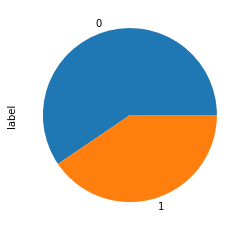

In [ ]:
df_train["label"].value_counts().plot.pie()

In [ ]:
# balance the dataset through downsampling
pos_subset = df_train[df_train.label == "1"]
neg_subset = df_train[df_train.label == "0"].sample(n=pos_subset.shape[0], random_state=1)
df_train = pd.concat([pos_subset, neg_subset]).sample(frac=1, random_state=1).reset_index(drop=True)

print(pos_subset.shape)
print(neg_subset.shape)
print(df_train.shape)

(89117, 2)
(89117, 2)
(178234, 2)


# Build ImageDataGenerators 

In [ ]:
batch_size = 64

img_data_generator = ImageDataGenerator(
    validation_split=0.2, 
    rescale=1/255, 
    horizontal_flip=True,
    vertical_flip=True)

train_data = img_data_generator.flow_from_dataframe(
    dataframe = df_train,
    directory = TRAIN_DIR,
    x_col="id",
    y_col="label",
    class_mode="binary",
    target_size = (96,96),
    color_mode = "rgb",
    batch_size = batch_size,
    seed = 1,
    subset="training")

val_data = img_data_generator.flow_from_dataframe(
    dataframe = df_train,
    directory = TRAIN_DIR,
    x_col="id",
    y_col="label",
    class_mode="binary",
    target_size = (96,96),
    color_mode = "rgb",
    batch_size = batch_size,
    seed = 1,
    subset="validation")



Found 142588 validated image filenames belonging to 2 classes.
Found 35646 validated image filenames belonging to 2 classes.


In [ ]:
test_files = os.listdir(TEST_DIR)

In [ ]:
df_test = pd.DataFrame({"id":test_files})
df_test.head()

,id
0,f92a6f09739c848e3827530e2c96b090bad3f2c2.tif
1,f13e5b15506693c232ada2ca7992ccfd32036842.tif
2,46eb06c3676f065aecba50109266bdd270a07443.tif
3,a798897b84653ad94668433e17c8c0d000d85132.tif
4,ca37b04d764f2267f85341125af749c6e5e90845.tif


In [ ]:
test_img_data_generator = ImageDataGenerator(rescale=1/255)

test_data = test_img_data_generator.flow_from_dataframe(
    dataframe = df_test,
    x_col="id",
    directory = TEST_DIR,
    class_mode=None,
    target_size = (96,96),
    color_mode = "rgb",
    batch_size = 32,
    shuffle=False)

Found 57458 validated image filenames.


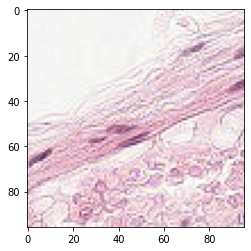

In [ ]:
# example image
plt.imshow(train_data.next()[0][0])

# Candidate Models

## model_crop_34
2.4M trainable parameters

In [ ]:
# # cropped to better fit the central portion of the image from which the labels are determined 
model_crop_34 = Sequential([
    InputLayer(input_shape=(96,96,3)),
    CenterCrop(34,34),     

    Conv2D(32,(3,3), padding="valid"),
    BatchNormalization(),
    Activation("relu"),
    Conv2D(32,(3,3), padding="same"),
    BatchNormalization(),
    Activation("relu"),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64,(3,3), padding="same"),
    BatchNormalization(),
    Activation("relu"),
    Conv2D(64,(3,3), padding="same"),
    BatchNormalization(),
    Activation("relu"),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(128,(3,3), padding="same"),
    BatchNormalization(),
    Activation("relu"),
    Conv2D(128,(3,3), padding="same"),
    BatchNormalization(),
    Activation("relu"),
    
    Flatten(),
    Dense(256),
    BatchNormalization(),
    Activation("relu"),
    
    Dense(1),
    Activation("sigmoid")
])

model_crop_34.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(.001), 
    metrics=['accuracy'])


In [ ]:
model_crop_34.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 center_crop (CenterCrop)    (None, 34, 34, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                        

In [ ]:
history_crop_34 = model_crop_34.fit(
    x=train_data,
    epochs=5,
    verbose="auto",
    validation_data=val_data,
    validation_steps=None,
    validation_freq=1,
    max_queue_size=10,
    workers=8
)

model_crop_34.save(model_path+"model_crop_34")

Epoch 1/5
2228/2228 [==============================] - 198s 83ms/step - loss: 0.4463 - accuracy: 0.7975 - val_loss: 0.4484 - val_accuracy: 0.8072
Epoch 2/5
2228/2228 [==============================] - 182s 82ms/step - loss: 0.3950 - accuracy: 0.8264 - val_loss: 0.5114 - val_accuracy: 0.7560
Epoch 3/5
2228/2228 [==============================] - 178s 80ms/step - loss: 0.3712 - accuracy: 0.8389 - val_loss: 0.3669 - val_accuracy: 0.8357
Epoch 4/5
2228/2228 [==============================] - 151s 68ms/step - loss: 0.3577 - accuracy: 0.8457 - val_loss: 0.4193 - val_accuracy: 0.8102
Epoch 5/5
2228/2228 [==============================] - 146s 65ms/step - loss: 0.3455 - accuracy: 0.8514 - val_loss: 0.6504 - val_accuracy: 0.7195


In [ ]:
# save model history
# convert history to DataFrame:     
df_history_crop_34 = pd.DataFrame(history_crop_34.history) 
df_history_crop_34["epoch"] = range(1,df_history_crop_34.shape[0]+1)

# save to csv: 
hist_csv_file = model_path+'history_crop_34.csv'
with open(hist_csv_file, mode='w') as f:
    df_history_crop_34.to_csv(f)

In [ ]:
df_history_crop_34.head()

,loss,accuracy,val_loss,val_accuracy,epoch
0,0.446278,0.797514,0.448377,0.807243,1
1,0.394983,0.826430,0.511445,0.755989,2
2,0.371186,0.838942,0.366939,0.835662,3
3,0.357651,0.845744,0.419299,0.810245,4
4,0.345531,0.851362,0.650384,0.719520,5


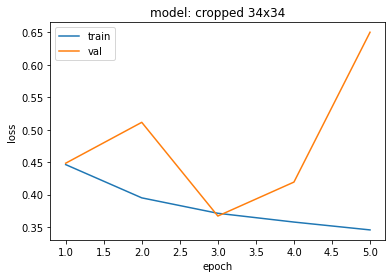

In [ ]:
plt.plot("epoch", "loss", data = df_history_crop_34)
plt.plot("epoch", "val_loss", data = df_history_crop_34)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title("model: cropped 34x34")
plt.show()

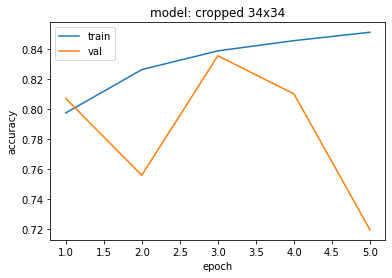

In [ ]:
plt.plot("epoch", "accuracy", data = df_history_crop_34)
plt.plot("epoch", "val_accuracy", data = df_history_crop_34)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title("model: cropped 34x34")
plt.show()

## model_crop_64
5.4M trainable parameters

In [ ]:
# moderate crop model (64x64)
model_crop_64 = Sequential([
    InputLayer(input_shape=(96,96,3)),
    CenterCrop(64,64),     
    Conv2D(32,(3,3), padding="same"),
    BatchNormalization(),
    Activation("relu"),

    Conv2D(64,(3,3), padding="same"),
    BatchNormalization(),
    Activation("relu"),
    Conv2D(64,(3,3), padding="same"),
    BatchNormalization(),
    Activation("relu"),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128,(3,3), padding="same"),
    BatchNormalization(),
    Activation("relu"),
    Conv2D(128,(3,3), padding="same"),
    BatchNormalization(),
    Activation("relu"),
    MaxPooling2D(pool_size=(2, 2)),
    

    Conv2D(256,(3,3), padding="same"),
    BatchNormalization(),
    Activation("relu"),
    Conv2D(256,(3,3), padding="same"),
    BatchNormalization(),
    Activation("relu"),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    Dense(256),
    BatchNormalization(),
    Activation("relu"),
    
    Dense(1),
    Activation("sigmoid")
])

model_crop_64.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(.001), 
    metrics=['accuracy'])


In [ ]:
model_crop_64.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 center_crop_1 (CenterCrop)  (None, 64, 64, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (None, 64, 64, 32)        896       
                                                                 
 batch_normalization_7 (Batc  (None, 64, 64, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_8 (Activation)   (None, 64, 64, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 batch_normalization_8 (Batc  (None, 64, 64, 64)       256       
 hNormalization)                                      

In [ ]:
history_crop_64 = model_crop_64.fit(
    x=train_data,
    epochs=5,
    verbose="auto",
    validation_data=val_data,
    validation_steps=None,
    validation_freq=1,
    max_queue_size=10,
    workers=8
)

model_crop_64.save(model_path+"model_crop_64")

Epoch 1/5
2228/2228 [==============================] - 182s 81ms/step - loss: 0.3795 - accuracy: 0.8343 - val_loss: 0.4259 - val_accuracy: 0.8167
Epoch 2/5
2228/2228 [==============================] - 169s 76ms/step - loss: 0.2899 - accuracy: 0.8803 - val_loss: 0.3913 - val_accuracy: 0.8309
Epoch 3/5
2228/2228 [==============================] - 167s 75ms/step - loss: 0.2527 - accuracy: 0.8975 - val_loss: 0.3220 - val_accuracy: 0.8712
Epoch 4/5
2228/2228 [==============================] - 166s 74ms/step - loss: 0.2317 - accuracy: 0.9089 - val_loss: 1.4129 - val_accuracy: 0.6579
Epoch 5/5
2228/2228 [==============================] - 166s 74ms/step - loss: 0.2174 - accuracy: 0.9137 - val_loss: 0.3051 - val_accuracy: 0.8823


In [ ]:
# save model history
# convert history to DataFrame:     
df_history_crop_64 = pd.DataFrame(history_crop_64.history) 
df_history_crop_64["epoch"] = range(1,df_history_crop_64.shape[0]+1)

# save to csv: 
hist_csv_file = model_path+'history_crop_64.csv'
with open(hist_csv_file, mode='w') as f:
    df_history_crop_64.to_csv(f)

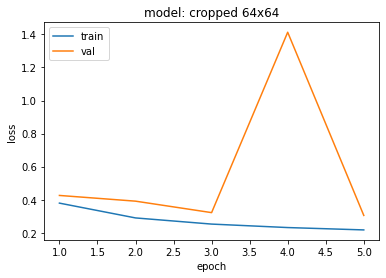

In [ ]:
plt.plot("epoch", "loss", data = df_history_crop_64)
plt.plot("epoch", "val_loss", data = df_history_crop_64)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title("model: cropped 64x64")
plt.show()

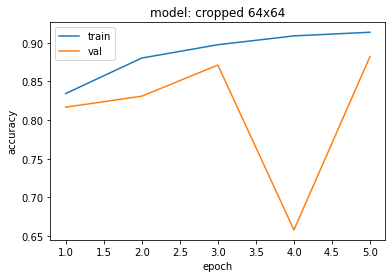

In [ ]:
plt.plot("epoch", "accuracy", data = df_history_crop_64)
plt.plot("epoch", "val_accuracy", data = df_history_crop_64)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title("model: cropped 64x64")
plt.show()

## model_raw
10.6M trainable parameters

In [ ]:
# uncropped image
model_raw = Sequential([
    Conv2D(32,(3,3), padding="same", input_shape=(96,96,3)),
    BatchNormalization(),
    Activation("relu"),
    
    Conv2D(64,(3,3), padding="same"),
    BatchNormalization(),
    Activation("relu"),
    Conv2D(64,(3,3), padding="same"),
    BatchNormalization(),
    Activation("relu"),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(128,(3,3), padding="same"),
    BatchNormalization(),
    Activation("relu"),
    Conv2D(128,(3,3), padding="same"),
    BatchNormalization(),
    Activation("relu"),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(256, (3,3), padding="same"),
    BatchNormalization(),
    Activation("relu"),
    Conv2D(256, (3,3), padding="same"),
    BatchNormalization(),
    Activation("relu"),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    Dense(256),
    BatchNormalization(),
    Activation("relu"),

    Dense(1),
    Activation("sigmoid")
])

model_raw.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(.001), 
    metrics=['accuracy'])

In [ ]:
model_raw.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 96, 96, 32)        896       
                                                                 
 batch_normalization_15 (Bat  (None, 96, 96, 32)       128       
 chNormalization)                                                
                                                                 
 activation_17 (Activation)  (None, 96, 96, 32)        0         
                                                                 
 conv2d_14 (Conv2D)          (None, 96, 96, 64)        18496     
                                                                 
 batch_normalization_16 (Bat  (None, 96, 96, 64)       256       
 chNormalization)                                                
                                                                 
 activation_18 (Activation)  (None, 96, 96, 64)       

In [ ]:
history_raw = model_raw.fit(
    x=train_data,
    epochs=5,
    verbose="auto",
    validation_data=val_data,
    validation_steps=None,
    validation_freq=1,
    max_queue_size=10,
    workers=8
)

model_raw.save(model_path+"model_raw")

Epoch 1/5
2228/2228 [==============================] - 220s 97ms/step - loss: 0.3343 - accuracy: 0.8578 - val_loss: 0.8712 - val_accuracy: 0.7246
Epoch 2/5
2228/2228 [==============================] - 218s 98ms/step - loss: 0.2302 - accuracy: 0.9099 - val_loss: 0.8792 - val_accuracy: 0.7529
Epoch 3/5
2228/2228 [==============================] - 216s 97ms/step - loss: 0.1949 - accuracy: 0.9255 - val_loss: 0.8099 - val_accuracy: 0.7806
Epoch 4/5
2228/2228 [==============================] - 215s 96ms/step - loss: 0.1744 - accuracy: 0.9339 - val_loss: 0.5693 - val_accuracy: 0.7721
Epoch 5/5
2228/2228 [==============================] - 215s 96ms/step - loss: 0.1611 - accuracy: 0.9401 - val_loss: 0.1884 - val_accuracy: 0.9287


In [ ]:
# save model history
# convert history to DataFrame:     
df_history_raw = pd.DataFrame(history_raw.history) 
df_history_raw["epoch"] = range(1,df_history_raw.shape[0]+1)

# save to csv: 
hist_csv_file = model_path+'history_raw.csv'
with open(hist_csv_file, mode='w') as f:
    df_history_raw.to_csv(f)

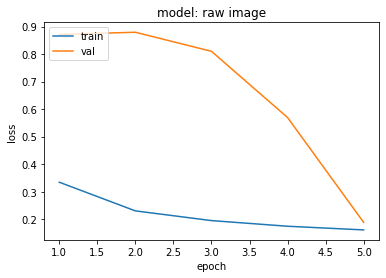

In [ ]:
plt.plot("epoch", "loss", data = df_history_raw)
plt.plot("epoch", "val_loss", data = df_history_raw)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title("model: raw image")
plt.show()

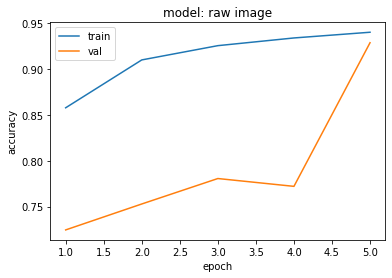

In [ ]:
plt.plot("epoch", "accuracy", data = df_history_raw)
plt.plot("epoch", "val_accuracy", data = df_history_raw)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title("model: raw image")
plt.show()

## model_raw_2
5.9M trainable parameters

In [ ]:
# FC layers: 128 -> 64
model_raw_2 = Sequential([
    Conv2D(32,(3,3), padding="same", input_shape=(96,96,3)),
    BatchNormalization(),
    Activation("relu"),
    
    Conv2D(64,(3,3), padding="same"),
    BatchNormalization(),
    Activation("relu"),
    Conv2D(64,(3,3), padding="same"),
    BatchNormalization(),
    Activation("relu"),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(128,(3,3), padding="same"),
    BatchNormalization(),
    Activation("relu"),
    Conv2D(128,(3,3), padding="same"),
    BatchNormalization(),
    Activation("relu"),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(256, (3,3), padding="same"),
    BatchNormalization(),
    Activation("relu"),
    Conv2D(256, (3,3), padding="same"),
    BatchNormalization(),
    Activation("relu"),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    Dense(128),
    BatchNormalization(),
    Activation("relu"),
    
    Dense(64),
    BatchNormalization(),
    Activation("relu"),

    Dense(1),
    Activation("sigmoid")
])

model_raw_2.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(.001), 
    metrics=['accuracy']
)

In [ ]:
model_raw_2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 96, 96, 32)        896       
                                                                 
 batch_normalization_23 (Bat  (None, 96, 96, 32)       128       
 chNormalization)                                                
                                                                 
 activation_26 (Activation)  (None, 96, 96, 32)        0         
                                                                 
 conv2d_21 (Conv2D)          (None, 96, 96, 64)        18496     
                                                                 
 batch_normalization_24 (Bat  (None, 96, 96, 64)       256       
 chNormalization)                                                
                                                                 
 activation_27 (Activation)  (None, 96, 96, 64)       

In [ ]:
history_raw_2 = model_raw_2.fit(
    x=train_data,
    epochs=5,
    verbose="auto",
    validation_data=val_data,
    validation_steps=None,
    validation_freq=1,
    max_queue_size=10,
    workers=8
)

model_raw_2.save(model_path+"model_raw_2")

Epoch 1/5
2228/2228 [==============================] - 239s 106ms/step - loss: 0.3174 - accuracy: 0.8673 - val_loss: 0.4934 - val_accuracy: 0.8353
Epoch 2/5
2228/2228 [==============================] - 220s 99ms/step - loss: 0.2215 - accuracy: 0.9128 - val_loss: 0.2774 - val_accuracy: 0.8898
Epoch 3/5
2228/2228 [==============================] - 219s 98ms/step - loss: 0.1906 - accuracy: 0.9279 - val_loss: 0.3690 - val_accuracy: 0.8521
Epoch 4/5
2228/2228 [==============================] - 217s 97ms/step - loss: 0.1707 - accuracy: 0.9352 - val_loss: 0.4407 - val_accuracy: 0.8143
Epoch 5/5
2228/2228 [==============================] - 235s 105ms/step - loss: 0.1554 - accuracy: 0.9421 - val_loss: 0.2591 - val_accuracy: 0.8984


In [ ]:
# save model history
# convert history to DataFrame:     
df_history_raw_2 = pd.DataFrame(history_raw_2.history) 
df_history_raw_2["epoch"] = range(1,df_history_raw_2.shape[0]+1)

# save to csv: 
hist_csv_file = model_path+'history_raw_2.csv'
with open(hist_csv_file, mode='w') as f:
    df_history_raw_2.to_csv(f)

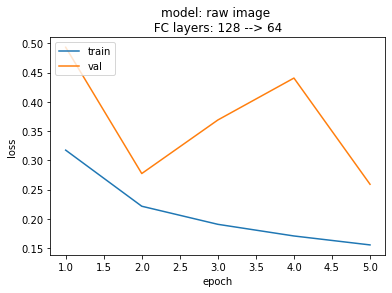

In [ ]:
plt.plot("epoch", "loss", data = df_history_raw_2)
plt.plot("epoch", "val_loss", data = df_history_raw_2)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title("model: raw image \n FC layers: 128 --> 64 ")
plt.show()

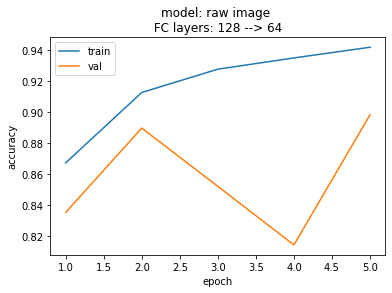

In [ ]:
plt.plot("epoch", "accuracy", data = df_history_raw_2)
plt.plot("epoch", "val_accuracy", data = df_history_raw_2)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title("model: raw image \n FC layers: 128 --> 64 ")
plt.show()

## model_raw_2_do
5.9M trainable parameters

In [ ]:
# FC layers: 128 -> 64; dropout between FC layers
model_raw_2_do = Sequential([
    Conv2D(32,(3,3), padding="same", input_shape=(96,96,3)),
    BatchNormalization(),
    Activation("relu"),
    
    Conv2D(64,(3,3), padding="same"),
    BatchNormalization(),
    Activation("relu"),
    Conv2D(64,(3,3), padding="same"),
    BatchNormalization(),
    Activation("relu"),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(128,(3,3), padding="same"),
    BatchNormalization(),
    Activation("relu"),
    Conv2D(128,(3,3), padding="same"),
    BatchNormalization(),
    Activation("relu"),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(256, (3,3), padding="same"),
    BatchNormalization(),
    Activation("relu"),
    Conv2D(256, (3,3), padding="same"),
    BatchNormalization(),
    Activation("relu"),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    Dense(128),
    BatchNormalization(),
    Activation("relu"),
    Dropout(0.5),
    
    Dense(64),
    BatchNormalization(),
    Activation("relu"),
    Dropout(0.5),

    Dense(1),
    Activation("sigmoid")
])

model_raw_2_do.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(.001), 
    metrics=['accuracy']
)

In [ ]:
model_raw_2_do.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_34 (Conv2D)          (None, 96, 96, 32)        896       
                                                                 
 batch_normalization_41 (Bat  (None, 96, 96, 32)       128       
 chNormalization)                                                
                                                                 
 activation_46 (Activation)  (None, 96, 96, 32)        0         
                                                                 
 conv2d_35 (Conv2D)          (None, 96, 96, 64)        18496     
                                                                 
 batch_normalization_42 (Bat  (None, 96, 96, 64)       256       
 chNormalization)                                                
                                                                 
 activation_47 (Activation)  (None, 96, 96, 64)       

In [ ]:
history_raw_2_do = model_raw_2_do.fit(
    x=train_data,
    epochs=5,
    verbose="auto",
    validation_data=val_data,
    validation_steps=None,
    validation_freq=1,
    max_queue_size=10,
    workers=8
)

model_raw_2_do.save(model_path+"model_raw_2_do")

Epoch 1/5
2228/2228 [==============================] - 222s 99ms/step - loss: 0.3433 - accuracy: 0.8576 - val_loss: 0.3630 - val_accuracy: 0.8476
Epoch 2/5
2228/2228 [==============================] - 236s 106ms/step - loss: 0.2398 - accuracy: 0.9073 - val_loss: 0.3713 - val_accuracy: 0.8596
Epoch 3/5
2228/2228 [==============================] - 220s 99ms/step - loss: 0.2066 - accuracy: 0.9219 - val_loss: 1.6414 - val_accuracy: 0.6340
Epoch 4/5
2228/2228 [==============================] - 219s 98ms/step - loss: 0.1860 - accuracy: 0.9310 - val_loss: 0.2305 - val_accuracy: 0.9080
Epoch 5/5
2228/2228 [==============================] - 218s 98ms/step - loss: 0.1747 - accuracy: 0.9357 - val_loss: 0.2305 - val_accuracy: 0.9150


In [ ]:
# save model history
# convert history to DataFrame:     
df_history_raw_2_do = pd.DataFrame(history_raw_2_do.history) 
df_history_raw_2_do["epoch"] = range(1,df_history_raw_2_do.shape[0]+1)

# save to csv: 
hist_csv_file = model_path+'history_raw_2_do.csv'
with open(hist_csv_file, mode='w') as f:
    df_history_raw_2_do.to_csv(f)

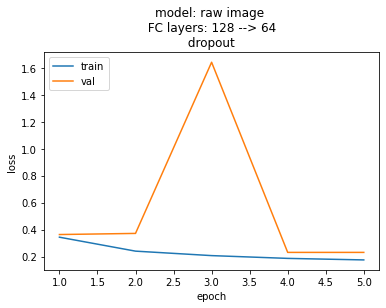

In [ ]:
plt.plot("epoch", "loss", data = df_history_raw_2_do)
plt.plot("epoch", "val_loss", data = df_history_raw_2_do)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title("model: raw image \n FC layers: 128 --> 64 \n dropout ")
plt.show()

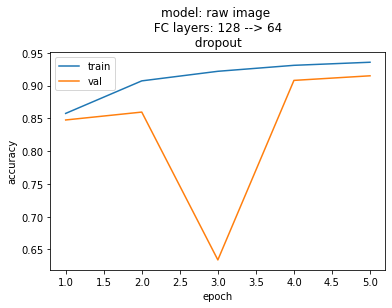

In [ ]:
plt.plot("epoch", "accuracy", data = df_history_raw_2_do)
plt.plot("epoch", "val_accuracy", data = df_history_raw_2_do)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title("model: raw image \n FC layers: 128 --> 64 \n dropout ")
plt.show()

In [ ]:
keras.backend.clear_session()

## model_2_crop_64_do
3.3M trainable parameters

In [ ]:
# moderate crop model (64x64) with dropout between FC layers
model_2_crop_64_do = Sequential([
    InputLayer(input_shape=(96,96,3)),
    CenterCrop(64,64),     
    Conv2D(32,(3,3), padding="same"),
    BatchNormalization(),
    Activation("relu"),

    Conv2D(64,(3,3), padding="same"),
    BatchNormalization(),
    Activation("relu"),
    Conv2D(64,(3,3), padding="same"),
    BatchNormalization(),
    Activation("relu"),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128,(3,3), padding="same"),
    BatchNormalization(),
    Activation("relu"),
    Conv2D(128,(3,3), padding="same"),
    BatchNormalization(),
    Activation("relu"),
    MaxPooling2D(pool_size=(2, 2)),
    

    Conv2D(256,(3,3), padding="same"),
    BatchNormalization(),
    Activation("relu"),
    Conv2D(256,(3,3), padding="same"),
    BatchNormalization(),
    Activation("relu"),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    Dense(128),
    BatchNormalization(),
    Activation("relu"),
    Dropout(0.5),

    Dense(64),
    BatchNormalization(),
    Activation("relu"),
    Dropout(0.5),

    Dense(1),
    Activation("sigmoid")
])

model_2_crop_64_do.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(.001), 
    metrics=['accuracy'])


In [ ]:
model_2_crop_64_do.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 center_crop_3 (CenterCrop)  (None, 64, 64, 3)         0         
                                                                 
 conv2d_41 (Conv2D)          (None, 64, 64, 32)        896       
                                                                 
 batch_normalization_50 (Bat  (None, 64, 64, 32)       128       
 chNormalization)                                                
                                                                 
 activation_56 (Activation)  (None, 64, 64, 32)        0         
                                                                 
 conv2d_42 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 batch_normalization_51 (Bat  (None, 64, 64, 64)       256       
 chNormalization)                                     

In [ ]:
history_2_crop_64_do = model_2_crop_64_do.fit(
    x=train_data,
    epochs=5,
    verbose="auto",
    validation_data=val_data,
    validation_steps=None,
    validation_freq=1,
    max_queue_size=10,
    workers=8
)

model_2_crop_64_do.save(model_path+"model_2_crop_64_do")

Epoch 1/5
2228/2228 [==============================] - 177s 78ms/step - loss: 0.3945 - accuracy: 0.8312 - val_loss: 0.4265 - val_accuracy: 0.8015
Epoch 2/5
2228/2228 [==============================] - 179s 80ms/step - loss: 0.3039 - accuracy: 0.8766 - val_loss: 0.5191 - val_accuracy: 0.8015
Epoch 3/5
2228/2228 [==============================] - 176s 79ms/step - loss: 0.2693 - accuracy: 0.8930 - val_loss: 0.3994 - val_accuracy: 0.8185
Epoch 4/5
2228/2228 [==============================] - 175s 79ms/step - loss: 0.2506 - accuracy: 0.9010 - val_loss: 0.9614 - val_accuracy: 0.7553
Epoch 5/5
2228/2228 [==============================] - 175s 79ms/step - loss: 0.2342 - accuracy: 0.9089 - val_loss: 0.3514 - val_accuracy: 0.8649


In [ ]:
# save model history
# convert history to DataFrame:     
df_history_2_crop_64_do = pd.DataFrame(history_2_crop_64_do.history) 
df_history_2_crop_64_do["epoch"] = range(1,df_history_2_crop_64_do.shape[0]+1)

# save to csv: 
hist_csv_file = model_path+'history_2_crop_64_do.csv'
with open(hist_csv_file, mode='w') as f:
    df_history_2_crop_64_do.to_csv(f)

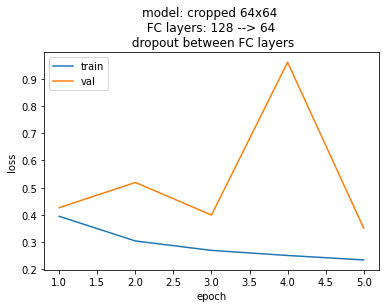

In [ ]:
plt.plot("epoch", "loss", data = df_history_2_crop_64_do)
plt.plot("epoch", "val_loss", data = df_history_2_crop_64_do)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title("model: cropped 64x64 \n FC layers: 128 --> 64 \n dropout between FC layers")
plt.show()

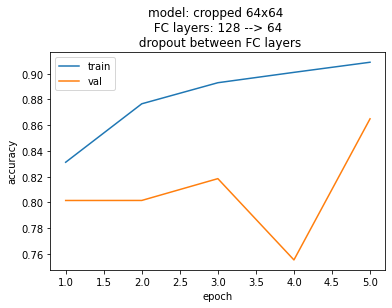

In [ ]:
plt.plot("epoch", "accuracy", data = df_history_2_crop_64_do)
plt.plot("epoch", "val_accuracy", data = df_history_2_crop_64_do)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title("model: cropped 64x64 \n FC layers: 128 --> 64 \n dropout between FC layers")
plt.show()

## model_2_crop_64
3.3M trainable parameters

In [ ]:
# moderate crop model (64x64)
model_2_crop_64 = Sequential([
    InputLayer(input_shape=(96,96,3)),
    CenterCrop(64,64),     
    Conv2D(32,(3,3), padding="same"),
    BatchNormalization(),
    Activation("relu"),

    Conv2D(64,(3,3), padding="same"),
    BatchNormalization(),
    Activation("relu"),
    Conv2D(64,(3,3), padding="same"),
    BatchNormalization(),
    Activation("relu"),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128,(3,3), padding="same"),
    BatchNormalization(),
    Activation("relu"),
    Conv2D(128,(3,3), padding="same"),
    BatchNormalization(),
    Activation("relu"),
    MaxPooling2D(pool_size=(2, 2)),
    

    Conv2D(256,(3,3), padding="same"),
    BatchNormalization(),
    Activation("relu"),
    Conv2D(256,(3,3), padding="same"),
    BatchNormalization(),
    Activation("relu"),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    Dense(128),
    BatchNormalization(),
    Activation("relu"),
    
    Dense(64),
    BatchNormalization(),
    Activation("relu"),

    Dense(1),
    Activation("sigmoid")
])

model_2_crop_64.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(.001), 
    metrics=['accuracy'])


In [ ]:
model_2_crop_64.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 center_crop_2 (CenterCrop)  (None, 64, 64, 3)         0         
                                                                 
 conv2d_27 (Conv2D)          (None, 64, 64, 32)        896       
                                                                 
 batch_normalization_32 (Bat  (None, 64, 64, 32)       128       
 chNormalization)                                                
                                                                 
 activation_36 (Activation)  (None, 64, 64, 32)        0         
                                                                 
 conv2d_28 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 batch_normalization_33 (Bat  (None, 64, 64, 64)       256       
 chNormalization)                                     

In [ ]:
history_2_crop_64 = model_2_crop_64.fit(
    x=train_data,
    epochs=5,
    verbose="auto",
    validation_data=val_data,
    validation_steps=None,
    validation_freq=1,
    max_queue_size=10,
    workers=8
)

model_2_crop_64.save(model_path+"model_2_crop_64")

Epoch 1/5
2228/2228 [==============================] - 177s 79ms/step - loss: 0.3688 - accuracy: 0.8396 - val_loss: 1.7728 - val_accuracy: 0.6668
Epoch 2/5
2228/2228 [==============================] - 173s 78ms/step - loss: 0.2849 - accuracy: 0.8823 - val_loss: 0.6669 - val_accuracy: 0.7485
Epoch 3/5
2228/2228 [==============================] - 172s 77ms/step - loss: 0.2496 - accuracy: 0.8992 - val_loss: 0.2647 - val_accuracy: 0.8918
Epoch 4/5
2228/2228 [==============================] - 177s 79ms/step - loss: 0.2308 - accuracy: 0.9083 - val_loss: 0.4753 - val_accuracy: 0.8133
Epoch 5/5
2228/2228 [==============================] - 173s 78ms/step - loss: 0.2166 - accuracy: 0.9141 - val_loss: 0.3032 - val_accuracy: 0.8724


In [ ]:
# save model history
# convert history to DataFrame:     
df_history_2_crop_64 = pd.DataFrame(history_2_crop_64.history) 
df_history_2_crop_64["epoch"] = range(1,df_history_2_crop_64.shape[0]+1)

# save to csv: 
hist_csv_file = model_path+'history_2_crop_64.csv'
with open(hist_csv_file, mode='w') as f:
    df_history_2_crop_64.to_csv(f)

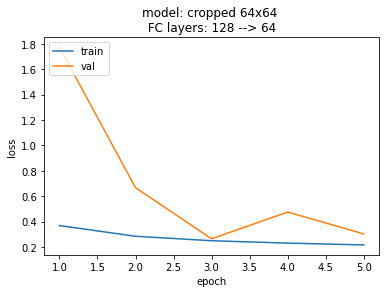

In [ ]:
plt.plot("epoch", "loss", data = df_history_2_crop_64)
plt.plot("epoch", "val_loss", data = df_history_2_crop_64)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title("model: cropped 64x64 \n FC layers: 128 --> 64 ")
plt.show()

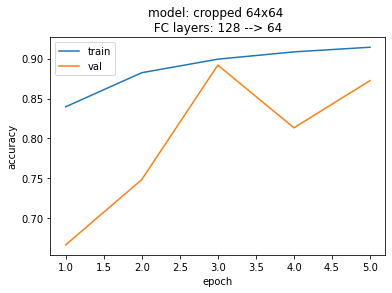

In [ ]:
plt.plot("epoch", "accuracy", data = df_history_2_crop_64)
plt.plot("epoch", "val_accuracy", data = df_history_2_crop_64)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title("model: cropped 64x64 \n FC layers: 128 --> 64 ")
plt.show()

# Final model

In [ ]:
# FC layers: 128 -> 64; dropout between FC layers
final_model = Sequential([
    Conv2D(32,(3,3), padding="same", input_shape=(96,96,3)),
    BatchNormalization(),
    Activation("relu"),
    
    Conv2D(64,(3,3), padding="same"),
    BatchNormalization(),
    Activation("relu"),
    Conv2D(64,(3,3), padding="same"),
    BatchNormalization(),
    Activation("relu"),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(128,(3,3), padding="same"),
    BatchNormalization(),
    Activation("relu"),
    Conv2D(128,(3,3), padding="same"),
    BatchNormalization(),
    Activation("relu"),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(256, (3,3), padding="same"),
    BatchNormalization(),
    Activation("relu"),
    Conv2D(256, (3,3), padding="same"),
    BatchNormalization(),
    Activation("relu"),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    Dense(128),
    BatchNormalization(),
    Activation("relu"),
    Dropout(0.5),
    
    Dense(64),
    BatchNormalization(),
    Activation("relu"),
    Dropout(0.5),

    Dense(1),
    Activation("sigmoid")
])

final_model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(), 
    metrics=['accuracy']
)

final_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_48 (Conv2D)          (None, 96, 96, 32)        896       
                                                                 
 batch_normalization_59 (Bat  (None, 96, 96, 32)       128       
 chNormalization)                                                
                                                                 
 activation_66 (Activation)  (None, 96, 96, 32)        0         
                                                                 
 conv2d_49 (Conv2D)          (None, 96, 96, 64)        18496     
                                                                 
 batch_normalization_60 (Bat  (None, 96, 96, 64)       256       
 chNormalization)                                                
                                                                 
 activation_67 (Activation)  (None, 96, 96, 64)       

In [ ]:
learner = ktrain.get_learner(
    model=final_model,
    train_data=train_data,
    val_data=val_data,
    workers=8,
    batch_size=32
)

In [ ]:
learner.lr_find()

simulating training for different learning rates... this may take a few moments...
Epoch 1/1024
4455/4455 [==============================] - 106s 23ms/step - loss: 0.9564 - accuracy: 0.6688


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


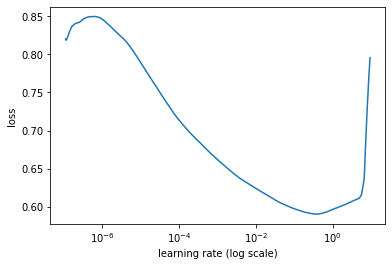

In [ ]:
learner.lr_plot()

In [ ]:
final_history = learner.autofit(
    lr=1e-1,
    epochs = 40,
    early_stopping=5,
    reduce_on_plateau=3
)



begin training using triangular learning rate policy with max lr of 0.1...
Epoch 1/40
4456/4456 [==============================] - 260s 58ms/step - loss: 0.4260 - accuracy: 0.8177 - val_loss: 0.2977 - val_accuracy: 0.8715
Epoch 2/40
4456/4456 [==============================] - 248s 56ms/step - loss: 0.3593 - accuracy: 0.8537 - val_loss: 0.2330 - val_accuracy: 0.9062
Epoch 3/40
4456/4456 [==============================] - 247s 55ms/step - loss: 0.3280 - accuracy: 0.8681 - val_loss: 0.2115 - val_accuracy: 0.9164
Epoch 4/40
4456/4456 [==============================] - 245s 55ms/step - loss: 0.3085 - accuracy: 0.8738 - val_loss: 0.1989 - val_accuracy: 0.9252
Epoch 5/40
4456/4456 [==============================] - 246s 55ms/step - loss: 0.3015 - accuracy: 0.8759 - val_loss: 0.1874 - val_accuracy: 0.9276
Epoch 6/40
4456/4456 [==============================] - 239s 54ms/step - loss: 0.2933 - accuracy: 0.8825 - val_loss: 0.1784 - val_accuracy: 0.9330
Epoch 7/40
4456/4456 [===================

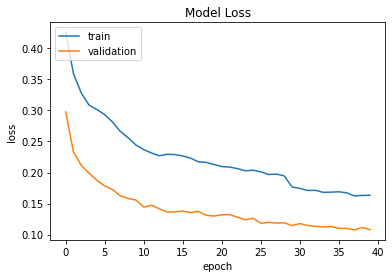

In [ ]:
learner.plot("loss")

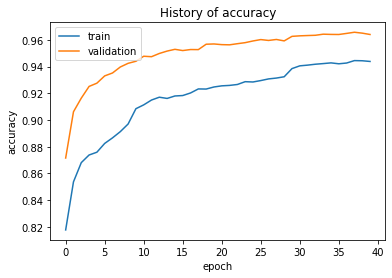

In [ ]:
learner.plot("accuracy")

In [ ]:
learner.save_model(model_path+'final_model')

In [ ]:
df_final_history = pd.DataFrame()
df_final_history["loss"]=final_history.history["loss"]
df_final_history["val_loss"]=final_history.history["val_loss"]
df_final_history["accuracy"]=final_history.history["accuracy"]
df_final_history["val_accuracy"]=final_history.history["val_accuracy"]
df_final_history["epoch"] = range(1,df_final_history.shape[0]+1)
df_final_history.head()

,loss,val_loss,accuracy,val_accuracy,epoch
0,0.425954,0.297704,0.817656,0.871514,1
1,0.359279,0.232996,0.853662,0.906161,2
2,0.327960,0.211489,0.868060,0.916372,3
3,0.308534,0.198945,0.873783,0.925153,4
4,0.301501,0.187432,0.875866,0.927594,5


In [ ]:
# save to csv: 
hist_csv_file = model_path+'final_history.csv'
with open(hist_csv_file, mode='w') as f:
    df_final_history.to_csv(f)

# Generate test predictions and save as .csv

In [ ]:
learner = ktrain.get_learner(
    model=final_model, 
    train_data=train_data,
    val_data=val_data,
    workers=8,
    batch_size=32
    )

In [ ]:
preds = learner.predict(test_data)

In [ ]:
preds[:5]

array([[0.01457799],
       [0.00523104],
       [0.9899951 ],
       [0.43776897],
       [1.        ]], dtype=float32)

In [ ]:
# Save predictions as submission.csv
df_submission = df_test.copy()
df_submission["id"] = df_submission["id"].str[:-4]
df_submission["label"] = preds

submission_filepath = model_path+'submission.csv'
with open(submission_filepath, mode='w') as f:
    df_submission.to_csv(f, index=False)